In [3]:
# Importing related packages

import pandas as pd
import numpy as np
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import matplotlib.font_manager as font_manager
from scipy.stats import iqr
import math
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from keras import backend as K
from sklearn.model_selection import GridSearchCV
import statsmodels.formula.api as smf
from matplotlib.transforms import ScaledTranslation

fontname = 'Times New Roman'
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

Using TensorFlow backend.


In [4]:
# Reading dataset
car_df = pd.read_csv('deep_data_final_car.csv')
truck_df = pd.read_csv('deep_data_final_truck.csv')

In [5]:
# refining data
car_df = car_df[['H', 'W', 'C_x', 'C_y', 'gps_dist', 'unit', 'vehicle']]
truck_df = truck_df[['H', 'W', 'C_x', 'C_y', 'gps_dist', 'unit', 'vehicle']]
df = pd.concat([car_df, truck_df])

In [6]:
# mapping camera height 
df['vehicle_dummy']= pd.get_dummies(df.vehicle).car
mapping = {10:45, 12:60, 13:28, 17:79.5}
df.replace({"unit": mapping}, inplace=True)
df.head()

,H,W,C_x,C_y,gps_dist,unit,vehicle,vehicle_dummy
0,185,286,303.0,444.5,7.507966,45.0,car,1
1,185,286,303.0,441.5,7.507966,45.0,car,1
2,182,280,302.0,440.0,7.507966,45.0,car,1
3,174,266,309.0,439.0,7.717238,45.0,car,1
4,142,216,336.0,423.0,8.586157,45.0,car,1


In [7]:
# Splitting the dataset into the Training set and Test set
X = df[['H', 'W', 'C_x', 'C_y', 'unit', 'vehicle','vehicle_dummy']].values
y = df[['gps_dist']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [8]:
df_result = pd.DataFrame()

# Model training

# Regression

In [9]:
df_reg_train = pd.DataFrame(X_train, columns=['H', 'W', 'C_x', 'C_y', 'unit', 'vehicle','vehicle_dummy'])
df_reg_train['gps_dist'] = y_train
df_reg_test = pd.DataFrame(X_test, columns=['H', 'W', 'C_x', 'C_y', 'unit', 'vehicle','vehicle_dummy'])
df_reg_test['gps_dist'] = y_test

In [10]:
# using dictionary to convert specific columns
convert_dict = {'H': float,
                'W': float,
                'C_x': float,
                'C_y': float,
                'unit': float,
                'vehicle_dummy': float,
                'gps_dist': float,
                'vehicle': str
               }
df_reg_train = df_reg_train.astype(convert_dict)
df_reg_test = df_reg_test.astype(convert_dict)

In [11]:
df_reg_train

,H,W,C_x,C_y,unit,vehicle,vehicle_dummy,gps_dist
0,82.0,104.0,642.0,432.0,79.5,truck,0.0,23.110817
1,66.0,100.0,398.0,403.0,45.0,car,1.0,16.022805
2,45.0,48.0,442.0,389.5,45.0,truck,0.0,36.909683
3,116.0,120.0,468.0,447.0,79.5,truck,0.0,16.514592
4,23.0,38.0,491.0,439.5,79.5,car,1.0,42.943693
...,...,...,...,...,...,...,...,...
1895,103.0,128.0,448.0,500.5,79.5,car,1.0,12.147214
1896,145.0,206.0,743.0,442.5,28.0,truck,0.0,15.056597
1897,47.0,48.0,506.0,428.5,28.0,car,1.0,37.338742
1898,37.0,52.0,484.0,457.5,79.5,car,1.0,31.970192


In [12]:
df_reg_test

,H,W,C_x,C_y,unit,vehicle,vehicle_dummy,gps_dist
0,121.0,166.0,385.0,420.5,45.0,car,1.0,15.382472
1,180.0,204.0,390.0,471.0,28.0,car,1.0,15.947480
2,60.0,78.0,483.0,442.0,60.0,car,1.0,22.683308
3,45.0,50.0,429.0,382.5,45.0,truck,0.0,36.909683
4,26.0,40.0,516.0,425.0,60.0,car,1.0,43.373707
...,...,...,...,...,...,...,...,...
470,39.0,44.0,504.0,426.5,28.0,car,1.0,42.604501
471,47.0,50.0,507.0,428.5,28.0,truck,0.0,35.947317
472,52.0,56.0,430.0,386.0,45.0,truck,0.0,33.540706
473,50.0,56.0,518.0,430.0,60.0,truck,0.0,33.512966


In [13]:
model_dic = {}
df_reg_final = pd.DataFrame()
for name, group in df_reg_train.groupby('unit'):
    df_reg_train_tmp = df_reg_train[df_reg_train.unit == name]
    df_reg_test_tmp = df_reg_test[df_reg_test.unit == name]
    mod = smf.ols(formula="gps_dist ~ C(vehicle) + H + W + C_x + C_y", data=df_reg_train_tmp)
    res = mod.fit()
    df_reg_test_tmp_p = df_reg_test_tmp[['vehicle', 'H', 'W', 'C_x', 'C_y']]
    df_reg_test_tmp['predict'] = res.predict(df_reg_test_tmp_p)
    df_reg_final = pd.concat([df_reg_final, df_reg_test_tmp])
    model_dic[str(name)] = [res, df_reg_test_tmp['predict'] - df_reg_test_tmp['gps_dist']]

In [14]:
r = []
for n , g in df_reg_final.groupby('vehicle'): 
    print(n)
    print('')
    for name, group in df_reg_final.groupby('unit'):
        res =  group.predict - group.gps_dist
        print('unit: ', name)
        print('mean: ', np.mean(res),'std: ', np.std(res))
        print('')
        r.append([np.mean(res), np.std(res), name, 'reg', n])

car

unit:  28.0
mean:  -0.0014094277608784145 std:  5.507081871717389

unit:  45.0
mean:  0.9876773340942878 std:  7.106748015924019

unit:  60.0
mean:  -0.6251965311041148 std:  8.905476906553886

unit:  79.5
mean:  -1.2977960570475477 std:  8.917542379781228

truck

unit:  28.0
mean:  -0.0014094277608784145 std:  5.507081871717389

unit:  45.0
mean:  0.9876773340942878 std:  7.106748015924019

unit:  60.0
mean:  -0.6251965311041148 std:  8.905476906553886

unit:  79.5
mean:  -1.2977960570475477 std:  8.917542379781228



In [15]:
r = pd.DataFrame(r,columns=['mean','std','unit','model','vehicle'])
df_result = pd.concat([df_result,r])

# ANN

In [16]:
# Feature Scaling
X_train_ann = np.delete(X_train, -2, 1)
X_test_ann = np.delete(X_test, -2, 1)
sc = StandardScaler()
X_train_ann = sc.fit_transform(X_train_ann)
X_test_ann = sc.transform(X_test_ann)

In [19]:
# Initialising the ANN
model = Sequential()

# Adding the input layer and the first hidden layer
model.add(Dense(8, activation = 'relu', input_dim = 6))
# Adding the second hidden layer
model.add(Dense(units = 7, activation = 'relu'))
# Adding the third hidden layer
model.add(Dense(units = 6, activation = 'relu'))
# Adding the third hidden layer
model.add(Dense(units = 5, activation = 'relu'))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the ANN

from keras import backend as K
def soft_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=[soft_acc])

# Fitting the ANN to the Training set
history = model.fit(X_train_ann, y_train, batch_size = 16, epochs = 800, validation_split=0.2)

Epoch 1/800
95/95 [==============================] - 1s 3ms/step - loss: 977.7681 - soft_acc: 4.4008e-04 - val_loss: 897.0923 - val_soft_acc: 0.0026
Epoch 2/800
95/95 [==============================] - 0s 1ms/step - loss: 678.8525 - soft_acc: 0.0047 - val_loss: 196.8675 - val_soft_acc: 0.0286
Epoch 3/800
95/95 [==============================] - 0s 1ms/step - loss: 111.0548 - soft_acc: 0.0354 - val_loss: 72.3306 - val_soft_acc: 0.0547
Epoch 4/800
95/95 [==============================] - 0s 993us/step - loss: 63.9177 - soft_acc: 0.0368 - val_loss: 51.4430 - val_soft_acc: 0.0990
Epoch 5/800
95/95 [==============================] - 0s 986us/step - loss: 44.6374 - soft_acc: 0.0569 - val_loss: 40.8294 - val_soft_acc: 0.0859
Epoch 6/800
95/95 [==============================] - 0s 983us/step - loss: 35.6379 - soft_acc: 0.0701 - val_loss: 35.8859 - val_soft_acc: 0.0712
Epoch 7/800
95/95 [==============================] - 0s 1ms/step - loss: 32.2220 - soft_acc: 0.0645 - val_loss: 33.2249 - val_s

Epoch 58/800
95/95 [==============================] - 0s 1ms/step - loss: 9.4434 - soft_acc: 0.2173 - val_loss: 12.7991 - val_soft_acc: 0.1970
Epoch 59/800
95/95 [==============================] - 0s 1ms/step - loss: 8.9709 - soft_acc: 0.1864 - val_loss: 12.5746 - val_soft_acc: 0.1936
Epoch 60/800
95/95 [==============================] - 0s 1ms/step - loss: 8.6585 - soft_acc: 0.2177 - val_loss: 12.3116 - val_soft_acc: 0.2161
Epoch 61/800
95/95 [==============================] - 0s 936us/step - loss: 8.5062 - soft_acc: 0.2292 - val_loss: 12.1630 - val_soft_acc: 0.2188
Epoch 62/800
95/95 [==============================] - 0s 930us/step - loss: 8.8092 - soft_acc: 0.2184 - val_loss: 12.5418 - val_soft_acc: 0.1979
Epoch 63/800
95/95 [==============================] - 0s 1ms/step - loss: 8.7290 - soft_acc: 0.2110 - val_loss: 12.7523 - val_soft_acc: 0.1944
Epoch 64/800
95/95 [==============================] - 0s 1ms/step - loss: 9.2338 - soft_acc: 0.2177 - val_loss: 12.6169 - val_soft_acc: 0.

95/95 [==============================] - 0s 1ms/step - loss: 7.5414 - soft_acc: 0.2120 - val_loss: 11.2315 - val_soft_acc: 0.1866
Epoch 172/800
95/95 [==============================] - 0s 1ms/step - loss: 7.9801 - soft_acc: 0.1969 - val_loss: 11.2155 - val_soft_acc: 0.1823
Epoch 173/800
95/95 [==============================] - 0s 1ms/step - loss: 7.7007 - soft_acc: 0.1873 - val_loss: 11.0343 - val_soft_acc: 0.2205
Epoch 174/800
95/95 [==============================] - 0s 1ms/step - loss: 6.9014 - soft_acc: 0.2118 - val_loss: 11.1579 - val_soft_acc: 0.1875
Epoch 175/800
95/95 [==============================] - 0s 2ms/step - loss: 7.4360 - soft_acc: 0.2053 - val_loss: 11.3686 - val_soft_acc: 0.2170
Epoch 176/800
95/95 [==============================] - 0s 910us/step - loss: 7.6809 - soft_acc: 0.1936 - val_loss: 11.1698 - val_soft_acc: 0.1719
Epoch 177/800
95/95 [==============================] - 0s 877us/step - loss: 7.2790 - soft_acc: 0.2071 - val_loss: 11.8063 - val_soft_acc: 0.1788
Ep

95/95 [==============================] - 0s 953us/step - loss: 8.0900 - soft_acc: 0.1937 - val_loss: 11.1205 - val_soft_acc: 0.1771
Epoch 284/800
95/95 [==============================] - 0s 880us/step - loss: 7.5824 - soft_acc: 0.2033 - val_loss: 11.3655 - val_soft_acc: 0.1944
Epoch 285/800
95/95 [==============================] - 0s 879us/step - loss: 8.0234 - soft_acc: 0.2108 - val_loss: 11.2949 - val_soft_acc: 0.2240
Epoch 286/800
95/95 [==============================] - 0s 889us/step - loss: 7.4638 - soft_acc: 0.2088 - val_loss: 11.3768 - val_soft_acc: 0.2075
Epoch 287/800
95/95 [==============================] - 0s 885us/step - loss: 7.8763 - soft_acc: 0.2112 - val_loss: 11.1309 - val_soft_acc: 0.2066
Epoch 288/800
95/95 [==============================] - 0s 953us/step - loss: 6.9919 - soft_acc: 0.2257 - val_loss: 11.2939 - val_soft_acc: 0.1806
Epoch 289/800
95/95 [==============================] - 0s 881us/step - loss: 7.1394 - soft_acc: 0.2078 - val_loss: 11.2427 - val_soft_acc:

95/95 [==============================] - 0s 1ms/step - loss: 7.2007 - soft_acc: 0.2043 - val_loss: 11.5724 - val_soft_acc: 0.2023
Epoch 396/800
95/95 [==============================] - 0s 1ms/step - loss: 7.3298 - soft_acc: 0.2087 - val_loss: 11.2215 - val_soft_acc: 0.1823
Epoch 397/800
95/95 [==============================] - 0s 891us/step - loss: 7.0999 - soft_acc: 0.2262 - val_loss: 11.9521 - val_soft_acc: 0.1927
Epoch 398/800
95/95 [==============================] - 0s 889us/step - loss: 7.7356 - soft_acc: 0.2064 - val_loss: 11.4606 - val_soft_acc: 0.2049
Epoch 399/800
95/95 [==============================] - 0s 898us/step - loss: 7.3825 - soft_acc: 0.2059 - val_loss: 12.3440 - val_soft_acc: 0.1658
Epoch 400/800
95/95 [==============================] - 0s 874us/step - loss: 7.2339 - soft_acc: 0.2156 - val_loss: 11.4890 - val_soft_acc: 0.2101
Epoch 401/800
95/95 [==============================] - 0s 878us/step - loss: 7.5602 - soft_acc: 0.2128 - val_loss: 11.2387 - val_soft_acc: 0.1

95/95 [==============================] - 0s 893us/step - loss: 7.6460 - soft_acc: 0.2264 - val_loss: 10.9626 - val_soft_acc: 0.1745
Epoch 508/800
95/95 [==============================] - 0s 885us/step - loss: 7.3038 - soft_acc: 0.2130 - val_loss: 11.4274 - val_soft_acc: 0.2014
Epoch 509/800
95/95 [==============================] - 0s 886us/step - loss: 7.7475 - soft_acc: 0.2243 - val_loss: 11.0766 - val_soft_acc: 0.1927
Epoch 510/800
95/95 [==============================] - 0s 1ms/step - loss: 6.9914 - soft_acc: 0.2362 - val_loss: 11.9716 - val_soft_acc: 0.1658
Epoch 511/800
95/95 [==============================] - 0s 1ms/step - loss: 7.7555 - soft_acc: 0.2188 - val_loss: 10.9295 - val_soft_acc: 0.2023
Epoch 512/800
95/95 [==============================] - 0s 1ms/step - loss: 7.4833 - soft_acc: 0.2026 - val_loss: 11.1457 - val_soft_acc: 0.1632
Epoch 513/800
95/95 [==============================] - 0s 2ms/step - loss: 7.4653 - soft_acc: 0.2206 - val_loss: 10.9998 - val_soft_acc: 0.1875


95/95 [==============================] - 0s 899us/step - loss: 6.9963 - soft_acc: 0.2238 - val_loss: 10.9530 - val_soft_acc: 0.1649
Epoch 620/800
95/95 [==============================] - 0s 878us/step - loss: 7.9423 - soft_acc: 0.2303 - val_loss: 11.9110 - val_soft_acc: 0.2153
Epoch 621/800
95/95 [==============================] - 0s 895us/step - loss: 8.3500 - soft_acc: 0.1954 - val_loss: 11.5835 - val_soft_acc: 0.2066
Epoch 622/800
95/95 [==============================] - 0s 886us/step - loss: 6.7827 - soft_acc: 0.2181 - val_loss: 10.8057 - val_soft_acc: 0.1918
Epoch 623/800
95/95 [==============================] - 0s 906us/step - loss: 8.3954 - soft_acc: 0.2010 - val_loss: 10.9395 - val_soft_acc: 0.1849
Epoch 624/800
95/95 [==============================] - 0s 1ms/step - loss: 7.2889 - soft_acc: 0.2222 - val_loss: 11.9030 - val_soft_acc: 0.2040
Epoch 625/800
95/95 [==============================] - 0s 1ms/step - loss: 7.3960 - soft_acc: 0.2124 - val_loss: 11.7309 - val_soft_acc: 0.2

95/95 [==============================] - 0s 959us/step - loss: 6.3763 - soft_acc: 0.2213 - val_loss: 10.8435 - val_soft_acc: 0.1953
Epoch 732/800
95/95 [==============================] - 0s 1ms/step - loss: 6.9664 - soft_acc: 0.2317 - val_loss: 10.8456 - val_soft_acc: 0.2075
Epoch 733/800
95/95 [==============================] - 0s 1ms/step - loss: 7.2806 - soft_acc: 0.2313 - val_loss: 10.9415 - val_soft_acc: 0.2066
Epoch 734/800
95/95 [==============================] - 0s 916us/step - loss: 7.6460 - soft_acc: 0.2249 - val_loss: 10.8629 - val_soft_acc: 0.2014
Epoch 735/800
95/95 [==============================] - 0s 979us/step - loss: 7.2669 - soft_acc: 0.2023 - val_loss: 12.7252 - val_soft_acc: 0.1858
Epoch 736/800
95/95 [==============================] - 0s 916us/step - loss: 7.6272 - soft_acc: 0.2039 - val_loss: 10.9312 - val_soft_acc: 0.1875
Epoch 737/800
95/95 [==============================] - 0s 936us/step - loss: 7.7930 - soft_acc: 0.2395 - val_loss: 11.0602 - val_soft_acc: 0.2

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 56        
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 63        
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 48        
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 35        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 6         
Total params: 208
Trainable params: 208
Non-trainable params: 0
_________________________________________________________________


In [21]:
df_ann_test = pd.DataFrame(sc.inverse_transform(X_test_ann), columns=['H', 'W', 'C_x', 'C_y', 'unit', 'vehicle_dummy'])
df_ann_test['gps_dist'] = y_test
df_ann_test['predict'] = model.predict(X_test_ann)

In [22]:
df_ann_test

,H,W,C_x,C_y,unit,vehicle_dummy,gps_dist,predict
0,121.0,166.0,385.0,420.5,45.0,1.0,15.382472,10.651908
1,180.0,204.0,390.0,471.0,28.0,1.0,15.947480,8.624960
2,60.0,78.0,483.0,442.0,60.0,1.0,22.683308,19.139475
3,45.0,50.0,429.0,382.5,45.0,0.0,36.909683,37.008690
4,26.0,40.0,516.0,425.0,60.0,1.0,43.373707,46.035728
...,...,...,...,...,...,...,...,...
470,39.0,44.0,504.0,426.5,28.0,1.0,42.604501,41.101048
471,47.0,50.0,507.0,428.5,28.0,0.0,35.947317,36.093418
472,52.0,56.0,430.0,386.0,45.0,0.0,33.540706,32.987476
473,50.0,56.0,518.0,430.0,60.0,0.0,33.512966,33.678413


In [23]:
r = []
for n , g in df_ann_test.groupby('vehicle_dummy'): 
    print(n)
    if n == 0:
        n = 'truck'
    else:
        n = 'car'
    print('')
    for name, group in g.groupby('unit'):
        res =  group.predict - group.gps_dist
        print('unit: ', name)
        print('mean: ', np.mean(res),'std: ', np.std(res))
        print('')
        r.append([np.mean(res), np.std(res), name, 'ann', n])

0.0

unit:  28.0
mean:  -0.7722046848283918 std:  3.6034686840573174

unit:  45.0
mean:  -0.20603791446342729 std:  1.1509137767062045

unit:  60.0
mean:  -0.015982219054372904 std:  1.6817443312539468

unit:  79.5
mean:  -0.4181351168987536 std:  3.6563985044094864

1.0

unit:  28.0
mean:  0.3843684862026622 std:  3.3966856295115377

unit:  45.0
mean:  0.5582762519299376 std:  2.825417030900864

unit:  60.0
mean:  -1.2448268921346903 std:  2.3905181008646537

unit:  79.5
mean:  0.12418164930546141 std:  4.519807885187755



In [24]:
r = pd.DataFrame(r,columns=['mean','std','unit','model','vehicle'])
df_result = pd.concat([df_result,r])

# Pinhole model

In [25]:
def dist_cal_by_model(x, y):
    if y == 'car':
        return 851 * 1.445 / x
    else: #for pickup truck
        return 934 * 1.920 / x

In [26]:
df_pin_test = pd.DataFrame(X_test, columns=['H', 'W', 'C_x', 'C_y', 'unit', 'vehicle','vehicle_dummy'])
df_pin_test['gps_dist'] = y_test
df_pin_test['predict'] = np.vectorize(dist_cal_by_model)(df_pin_test['H'], df_pin_test['vehicle'])

In [27]:
r = []
for n , g in df_pin_test.groupby('vehicle'): 
    print(n)
    print('')
    for name, group in g.groupby('unit'):
        res =  group.predict - group.gps_dist
        print('unit: ', name)
        print('mean: ', np.mean(res),'std: ', np.std(res))
        print('')
        r.append([np.mean(res), np.std(res), name, 'pin', n])

car

unit:  28.0
mean:  -7.814054927644907 std:  3.4813983970937965

unit:  45.0
mean:  1.0552302014618276 std:  4.6893603309609295

unit:  60.0
mean:  0.5221440413565003 std:  2.9132852672291616

unit:  79.5
mean:  1.9966328623779288 std:  6.0746761913159455

truck

unit:  28.0
mean:  -0.2927863968211002 std:  4.561209335681658

unit:  45.0
mean:  0.9677752937623209 std:  1.5407142693237292

unit:  60.0
mean:  0.7395593826965754 std:  1.4144145853773102

unit:  79.5
mean:  -0.04764107678125455 std:  4.652909010307651



In [28]:
r = pd.DataFrame(r,columns=['mean','std','unit','model', 'vehicle'])
df_result = pd.concat([df_result,r])

In [29]:
df_car = df_result[df_result.vehicle == 'truck']

In [30]:
df_car.reset_index(drop=1)

,mean,std,unit,model,vehicle
0,-0.001409,5.507082,28.0,reg,truck
1,0.987677,7.106748,45.0,reg,truck
2,-0.625197,8.905477,60.0,reg,truck
3,-1.297796,8.917542,79.5,reg,truck
4,-0.772205,3.603469,28.0,ann,truck
5,-0.206038,1.150914,45.0,ann,truck
6,-0.015982,1.681744,60.0,ann,truck
7,-0.418135,3.656399,79.5,ann,truck
8,-0.292786,4.561209,28.0,pin,truck
9,0.967775,1.540714,45.0,pin,truck


In [31]:
# df_car.columns = ['mean_1', 'std_1', 'unit', 'model', 'vehicle']
df_car['mean'].values

array([-0.00140943,  0.98767733, -0.62519653, -1.29779606, -0.77220468,
       -0.20603791, -0.01598222, -0.41813512, -0.2927864 ,  0.96777529,
        0.73955938, -0.04764108])

In [32]:
df_car['mean'] = [-1.40942776e-03,  9.87677334e-01, -6.25196531e-01, -1.29779606e+00,
        3.53865312e-01,  2.29753753e-01, -1.19600906e+00, -7.06992966e-02,
       .4342,  1.05523020e+00,  5.22144041e-01,  1.99663286e+00]

In [33]:
df_car['unit_m'] = df_car.unit * 0.0254

(array([-15., -10.,  -5.,   0.,   5.,  10.,  15.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

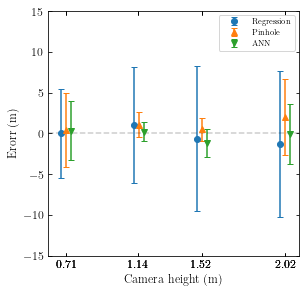

In [34]:
fig = plt.figure(figsize=(4.5,4.5))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Camera height (m)', fontsize=12, style = 'italic', weight='bold')
ax1.set_ylabel('Erorr (m)', fontsize=12,style = 'italic', weight='bold')
trans1 = ax1.transData + ScaledTranslation(-5/72, 0, fig.dpi_scale_trans)
trans2 = ax1.transData + ScaledTranslation(0, 0, fig.dpi_scale_trans)
trans3 = ax1.transData + ScaledTranslation(+5/72, 0, fig.dpi_scale_trans)
ax1.set_xlim([0.6,2.1])
ax1.set_ylim([-15,15])
ax1.errorbar(df_car[df_car.model == 'reg'].unit_m.values, df_car[df_car.model == 'reg']['mean'].values,
             yerr=df_car[df_car.model == 'reg']['std'].values,marker="o", linestyle="none", transform = trans1,
            label = 'Regression')
ax1.errorbar(df_car[df_car.model == 'pin'].unit_m.values, df_car[df_car.model == 'pin']['mean'].values ,
             yerr=df_car[df_car.model == 'pin']['std'].values,marker="^", linestyle="none", transform = trans2,
            label = 'Pinhole')
ax1.errorbar(df_car[df_car.model == 'ann'].unit_m.values, df_car[df_car.model == 'ann']['mean'].values,
             yerr=df_car[df_car.model == 'ann']['std'].values,marker="v", linestyle="none", transform = trans3,
            label = 'ANN')
ax1.legend(loc='best', scatterpoints = 1, fontsize=8)
ax1.axhline(ls = '--', alpha = .2, c='k')
ax1.set_xticks(np.round(df_car.unit_m.values,2))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.savefig('errorbar_truck.pdf',dpi=400)


In [50]:
!pwd

/Users/saeedarabi/Downloads


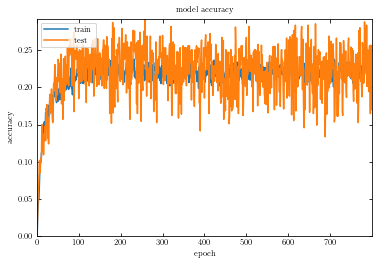

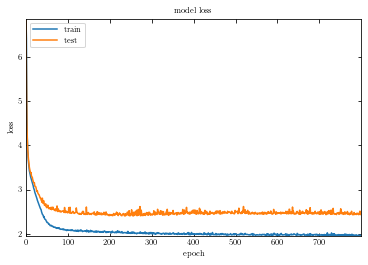

In [35]:
# summarize history for accuracy
plt.plot(history.history['soft_acc'])
plt.plot(history.history['val_soft_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(np.log(history.history['loss']))
plt.plot(np.log(history.history['val_loss']))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [355]:
df_ann_test

,H,W,C_x,C_y,unit,vehicle_dummy,gps_dist,predict
0,121.0,166.0,385.0,420.5,45.0,1.0,15.382472,11.134441
1,180.0,204.0,390.0,471.0,28.0,1.0,15.947480,10.421755
2,60.0,78.0,483.0,442.0,60.0,1.0,22.683308,20.302671
3,45.0,50.0,429.0,382.5,45.0,0.0,36.909683,37.129906
4,26.0,40.0,516.0,425.0,60.0,1.0,43.373707,45.295811
...,...,...,...,...,...,...,...,...
470,39.0,44.0,504.0,426.5,28.0,1.0,42.604501,40.996113
471,47.0,50.0,507.0,428.5,28.0,0.0,35.947317,36.435474
472,52.0,56.0,430.0,386.0,45.0,0.0,33.540706,33.804893
473,50.0,56.0,518.0,430.0,60.0,0.0,33.512966,33.870205


Text(0, 0.5, 'Residual (m)')

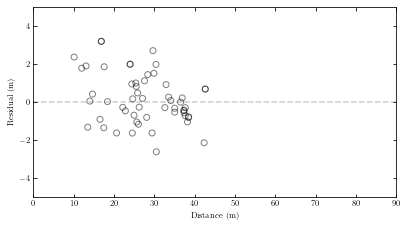

In [364]:
df_tmp_car = df_ann_test[(df_ann_test.vehicle_dummy == 0) & (df_ann_test.unit == 45)] # 0:truck, 1:car
fig = plt.figure(figsize=(6.5,3.5))
ax1 = fig.add_subplot(111)
ax1.scatter(df_tmp_car.gps_dist, df_tmp_car.predict - df_tmp_car.gps_dist, alpha=.5, facecolors='none', edgecolors='k')
ax1.set_xlim([0,90])
ax1.set_ylim([-5,5])
ax1.axhline(ls = '--', alpha = .2, c='k')
dft = df_tmp_car[(df_tmp_car.gps_dist<10) & (df_tmp_car.gps_dist>0)]
ax1.set_xlabel('Distance (m)', fontsize=8, style = 'italic', weight='bold')
ax1.set_ylabel('Residual (m)', fontsize=8,style = 'italic', weight='bold')
# plt.savefig('residuals_truck.pdf',dpi=400)

45.0


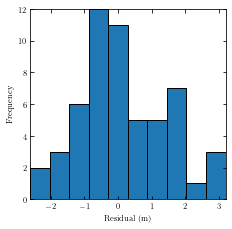

In [365]:
for name, group in df_tmp_car.groupby('unit'):
    print(name)
    fig = plt.figure(figsize=(3.5,3.5))
    ax1 = fig.add_subplot(111)
    ax1.hist(group.predict - group.gps_dist)
    ax1.set_xlabel('Residual (m)', fontsize=8, style = 'italic', weight='bold')
    ax1.set_ylabel('Frequency', fontsize=8,style = 'italic', weight='bold')
    plt.savefig('dist_truck_{}.pdf'.format(name),dpi=400)

In [ ]:
def f(x):
    val = x['y_pred'] - x['y_test']
    return pd.Series([np.mean(val), np.std(val), iqr(val)]).reset_index(drop = True)

df = pd.DataFrame(sc.inverse_transform(X_test), columns=['H', 'W', 'C_x', 'C_y', 'unit', 'vehicle'])
df['y_pred'] = y_pred
df['y_test'] = y_test
df = df[df['vehicle'] == 0]

# df = df.groupby('unit')

df = df.groupby('unit').apply(f).reset_index()
df.columns = ['unit_h', 'deep model mean', 'deep model std','deep model iqr' ]
df['unit_name'] = [ "Unit 13 \n (0.71)", "Unit 10 \n (1.14 m)", "Unit 12 \n (1.52)", "Unit 17 \n (2 m)"]
df.index = df['unit_name']

In [ ]:
df.head()

In [ ]:
for name, group in df:
    print(name)
    plt.figure()
    plt.hist(group.y_pred - group.y_test)
    plt.show()

In [ ]:
df['truck_mean'] = df_truck.mean().values
df['truck_std'] = df_truck.std()
df['truck_iqr'] = iqr(df_truck, axis = 0)
df['car_mean'] = df_car.mean()
df['car_std'] = df_car.std()
df['car_iqr'] = iqr(df_car, axis = 0)

df

In [ ]:
mean_truck = [-0.2492995561347824]
std_truck = [2.70862288681874]
std_car = [3.7408812882449993]
mean_car = [-0.12542908901759484]
print([df_truck.values.mean(), df_car.dropna().values.mean()])
print([df_truck.values.std(), df_car.dropna().values.std()])

In [ ]:
df[['unit_h', 'deep model mean', 'deep model std', 'deep model iqr',
        'truck_mean', 'truck_std', 'truck_iqr', 'car_mean',
       'car_std', 'car_iqr']]

In [ ]:
plt.figure(figsize=(5,15))
df[['deep model mean', 'truck_mean']].plot(kind='bar', yerr=df[['deep model std', 'truck_std']].values.T, xlabel='unit', ylabel='error (m)', figsize=(10,5)) 
plt.legend(["Deep model", 'Pinhole model'])

In [ ]:
ax = df.mean().plot(legend=False,kind="bar",
                          color="red",rot=0,fontsize=16,yerr=df.std(), figsize=(6.5,6.5))
font = font_manager.FontProperties(family = fontname, style='italic', size=14)
plt.xticks(weight = 'bold', style = 'italic', fontname = fontname, fontsize=14)
plt.yticks(weight = 'bold', style = 'italic', fontname = fontname, fontsize=14)
plt.xlabel('Units', fontsize=16,style = 'italic', weight='bold', fontname=fontname)
plt.ylabel('Distance Error (m)', fontsize=16,style = 'italic', weight='bold', fontname=fontname)
ax.set_ylim((-5,5))


In [ ]:
plt.figure(figsize=(15,3))
plt.scatter(range(len(y_test)), y_test, color = 'red', label = 'Real data')
plt.scatter(range(len(y_pred)), y_pred, color = 'blue', label = 'Predicted data')
plt.figure(figsize=(15, 3))
plt.scatter(range(len(y_pred)), (y_test - y_pred), color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()

In [ ]:
np.std(y_test - y_pred)

In [ ]:
np.mean(y_test - y_pred)

In [ ]:
iqr(y_test - y_pred)

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(x=y_test.reshape(713,1), y=(y_pred.reshape(713,1) - y_test.reshape(713,1)), alpha=.2, facecolors='none', edgecolors='r')
# plt.gca().update(dict(xlabel='y_test', ylabel='residuals (y_pred - y_test)'))

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(x=y_test.reshape(713,1), y=(y_pred.reshape(713,1) - y_test.reshape(713,1)), alpha=.2, facecolors='none', edgecolors='r')

In [ ]:
columns = [ "Unit 13 \n (0.71)", "Unit 10 \n (1.14 m)", "Unit 12 \n (1.52)", "Unit 17 \n (2 m)"]
truck = [[0.056918, 0.265463, 0.213490, -0.082971],
[0.271355, 1.127730, 1.28477, 1.969870],
[0.392258, 0.318478, -0.042042, 0.520576],
[0.744019, 1.485808, 1.618756, 0.043278],
[ -0.013213, -0.249351, -0.274474, -0.067475],
[0.629137, 0.425123, 0.254424, 0.642990],
[0.204234, 0.661938, 0.512799, -0.007783],
[0.238437, 0.194066, -0.161833, -0.180112]]
df_truck = pd.DataFrame(truck, columns=columns)

ax = df_truck.mean().plot(legend=False,kind="bar",
                          color="red",rot=0,fontsize=16,yerr=df_truck.std(), figsize=(6.5,6.5))
font = font_manager.FontProperties(family = fontname, style='italic', size=14)
plt.xticks(weight = 'bold', style = 'italic', fontname = fontname, fontsize=14)
plt.yticks(weight = 'bold', style = 'italic', fontname = fontname, fontsize=14)
plt.xlabel('Units', fontsize=16,style = 'italic', weight='bold', fontname=fontname)
plt.ylabel('Distance Error (m)', fontsize=16,style = 'italic', weight='bold', fontname=fontname)
ax.set_ylim((-5,5))

In [ ]:
df_truck.head()

In [ ]:
df_truck.mean().values

In [ ]:
columns = [ "Unit 13 \n (0.71)", "Unit 10 \n (1.14 m)", "Unit 12 \n (1.52)", "Unit 17 \n (2 m)"]
car = [[-0.142094, -0.052965, 0.157796, 0.289925],
[-0.954387, -1.601214, 3.888085, -0.012008],
[0.926389, 2.075867, -0.298162, -1.160564], 
[3.827156, 1.483507, -0.245916, -0.611535], 
[-1.718267, 0.712902, 0.575612, 0.341381],
[np.nan, -0.944339, -0.768733, -1.230775],
[0.859783, 1.272305, -0.411629, 0.732448],
[1.329752, -0.407789, np.nan , 1.783246]]
df_car = pd.DataFrame(car, columns=columns)
df_car.dropna(inplace=True)

In [ ]:
df_car

In [ ]:
ax = df_car.mean().plot(legend=False,kind="bar",
                          color="red",rot=0,fontsize=10,yerr=df_car.std(), figsize=(6.5,6.5))
font = font_manager.FontProperties(family = fontname, style='italic', size=14)
plt.xticks(weight = 'bold', style = 'italic', fontname = fontname, fontsize=14)
plt.yticks(weight = 'bold', style = 'italic', fontname = fontname, fontsize=14)
plt.xlabel('Units', fontsize=16,style = 'italic', weight='bold', fontname=fontname)
plt.ylabel('Distance Error (m)', fontsize=16,style = 'italic', weight='bold', fontname=fontname)
ax.set_ylim((-5, 5))